In [47]:
from gas_turbine_cycle.gases import Air, KeroseneCombustionProducts, NaturalGasCombustionProducts
import pandas as pd
import matplotlib.pyplot as plt

def kelvin(temp_cels):
    return temp_cels + 273

def celsius(temp_kelv):
    return temp_kelv - 273


In [48]:
def get_gas_temp(T0=300, T_out = kelvin(400), pi_c=10, eta_c=0.84, eta_m=0.98, N=16, 
                 G_gas=50, G_fuel=0.9, eta_r=0.99, precision=0.001):
    """
    Возвращает значение температуры газа перед турбиной
    
    T0: температура на входе
    T_out: температура выхлопных газов
    pi_c: степень повышения давления в компрессоре
    eta_c: КПД процесса сжатия
    eta_m: механический КПД
    N: мощность на валу силовой турбины в МВт
    G_gas: расход газа
    G_fuel: расход топлива
    eta_r: КПД редуктора
    precision: точность
    """
    air = Air()
    air.T1 = T0
    gas = NaturalGasCombustionProducts()
    gas.T1 = T_out
    gas.T2 = 800
    gas.alpha = 2.5
    k_res = 1
    while k_res >= 0.001:
#       работа компрессора
        L_c = air.c_p_av_int * T0 * (pi_c ** ((air.k_av_int - 1) / air.k_av_int) - 1) / eta_c
#       температура за компрессором
        T_c = T0 + L_c / air.c_p_av_int
        k_old = air.k_av_int
#       уточнение теплоемкости
        air.T2 = T_c
        k_res = abs(air.k_av_int - k_old) / air.k_av_int
    G_air = G_gas - G_fuel
#   работа расширения
    L_ext = (L_c * G_air + N *1e6 / eta_r) / (eta_m * G_gas)
    k_gas_res = 1
    while k_gas_res >= 0.001:
#       Температура перед турбиной
        T_gas = T_out + L_ext / gas.c_p_av_int
#       уточнение теплоемкости газа
        k_gas_old = gas.k_av_int
        gas.T2 = T_gas
        k_gas_res = abs(k_gas_old - gas.k_av_int) / gas.k_av_int
    return T_gas


In [49]:
class12MW = pd.DataFrame.from_dict({
    'Engine': ['ГТУ-12ПГ-2', 'SGT-400', 'Mars 100'],
    'N': [12.9, 13.5, 11.87],
    'eta_e': [34.1, 36.4, 34.4],
    'pi_c': [15.9, 16.8, 16.3],
    'T_out': [496, 555, 485],
    'G_gas_out': [45.9, 39.4, 42.6]
})
class16MW = pd.DataFrame.from_dict({
    'Engine': ['ГТЭ-16ПА', 'SGT-500', 'Titan 130', 'Т16'],
    'N': [16.8, 19.7, 16.96, 16.5],
    'eta_e': [36.6, 34.7, 36.6, 37.0],
    'pi_c': [19.9, 13, 17.1, 19.0],
    'T_out': [481, 369, 490, 490],
    'G_gas_out': [56.3, 97.9, 54.7, 54.3]
})
class25MW = pd.DataFrame.from_dict({
    'Engine': ['ГТЭ-25П', 'SGT-600', 'Titan 250', 'LM2500', 'Т25'],
    'N': [23.8, 25.63, 22.5, 23.9, 22.4],
    'eta_e': [38.0, 35.4, 40.3, 34.35, 40.0],
    'pi_c': [27.3, 14, 24, 18.7, 24],
    'T_out': [473, 543, 465, 517, 465],
    'G_gas_out': [76.7, 80.4, 68.2, 71.7, 68.24]
})

gas = NaturalGasCombustionProducts()

class12MW['G_fuel'] = class12MW['N']*1e6 / (0.01 * class12MW['eta_e'] * gas.Q_n)
class16MW['G_fuel'] = class16MW['N']*1e6 / (0.01 * class16MW['eta_e'] * gas.Q_n)
class25MW['G_fuel'] = class25MW['N']*1e6 / (0.01 * class25MW['eta_e'] * gas.Q_n)

# расчет температуры газа
class12MW['T_gas'] = [get_gas_temp(T0=300, T_out=kelvin(T_out), pi_c=pi_c, N=N, G_gas=G_gas, G_fuel=G_fuel) 
                      for T_out, pi_c, N, G_gas, G_fuel in 
                      zip(class12MW.T_out, class12MW.pi_c, class12MW.N, class12MW.G_gas_out, class12MW.G_fuel)]
class16MW['T_gas'] = [get_gas_temp(T0=300, T_out=kelvin(T_out), pi_c=pi_c, N=N, G_gas=G_gas, G_fuel=G_fuel) 
                      for T_out, pi_c, N, G_gas, G_fuel in
                      zip(class16MW.T_out, class16MW.pi_c, class16MW.N, class16MW.G_gas_out, class16MW.G_fuel)]
class25MW['T_gas'] = [get_gas_temp(T0=300, T_out=kelvin(T_out), pi_c=pi_c, N=N, G_gas=G_gas, G_fuel=G_fuel) 
                      for T_out, pi_c, N, G_gas, G_fuel in
                      zip(class25MW.T_out, class25MW.pi_c, class25MW.N, class25MW.G_gas_out, class25MW.G_fuel)]

class12MW['C_e'] = 3600 / (class12MW['eta_e'] * 0.01 * gas.Q_n)
class16MW['C_e'] = 3600 / (class16MW['eta_e'] * 0.01 * gas.Q_n)
class25MW['C_e'] = 3600 / (class25MW['eta_e'] * 0.01 * gas.Q_n)

In [50]:
class12MW.round(6)

,Engine,G_gas_out,N,T_out,eta_e,pi_c,G_fuel,T_gas,C_e
0,ГТУ-12ПГ-2,45.9,12.90,496,34.1,15.9,0.781416,1354.580596,0.000218
1,SGT-400,39.4,13.50,555,36.4,16.8,0.766089,1465.386881,0.000204
2,Mars 100,42.6,11.87,485,34.4,16.3,0.712753,1347.028313,0.000216


In [51]:
class16MW.round(6)

,Engine,G_gas_out,N,T_out,eta_e,pi_c,G_fuel,T_gas,C_e
0,ГТЭ-16ПА,56.3,16.80,481,36.6,19.9,0.948146,1393.902206,0.000203
1,SGT-500,97.9,19.70,369,34.7,13.0,1.172691,1143.297658,0.000214
2,Titan 130,54.7,16.96,490,36.6,17.1,0.957176,1384.601577,0.000203
3,Т16,54.3,16.50,490,37.0,19.0,0.921148,1398.118807,0.000201


In [52]:
class25MW.round(6)

,Engine,G_gas_out,N,T_out,eta_e,pi_c,G_fuel,T_gas,C_e
0,ГТЭ-25П,76.70,23.80,473,38.00,27.3,1.293720,1457.349672,0.000196
1,SGT-600,80.40,25.63,543,35.40,14.0,1.495520,1405.672721,0.000210
2,Titan 250,68.20,22.50,465,40.30,24.0,1.153253,1441.492288,0.000185
3,LM2500,71.70,23.90,517,34.35,18.7,1.437203,1441.843809,0.000216
4,Т25,68.24,22.40,465,40.00,24.0,1.156738,1440.152244,0.000186


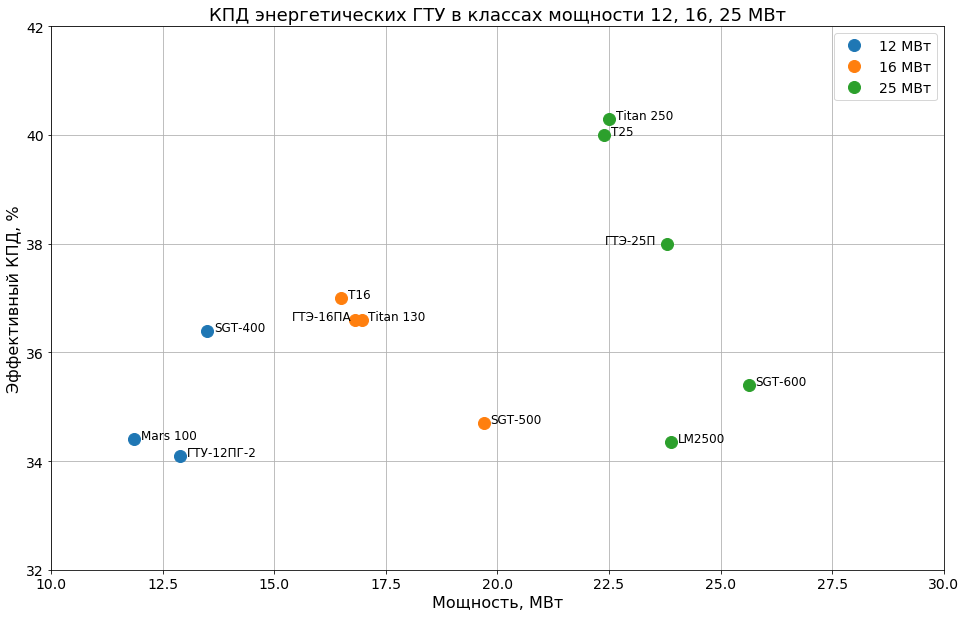

In [53]:
%matplotlib inline
plt.figure(figsize=(16, 10))

plt.plot(class12MW.N, class12MW.eta_e, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.eta_e[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.eta_e[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] + 0.15, class12MW.eta_e[2], class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.eta_e, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 1.4, class16MW.eta_e[0], class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.eta_e[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.eta_e[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] + 0.15, class16MW.eta_e[3], class16MW.Engine[3], fontsize=12)

plt.plot(class25MW.N, class25MW.eta_e, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.eta_e[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.eta_e[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] + 0.15, class25MW.eta_e[2], class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.eta_e[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] + 0.15, class25MW.eta_e[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Эффективный КПД, %', fontsize=16)
plt.title('КПД энергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.ylim(32, 42)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots\eff.png')

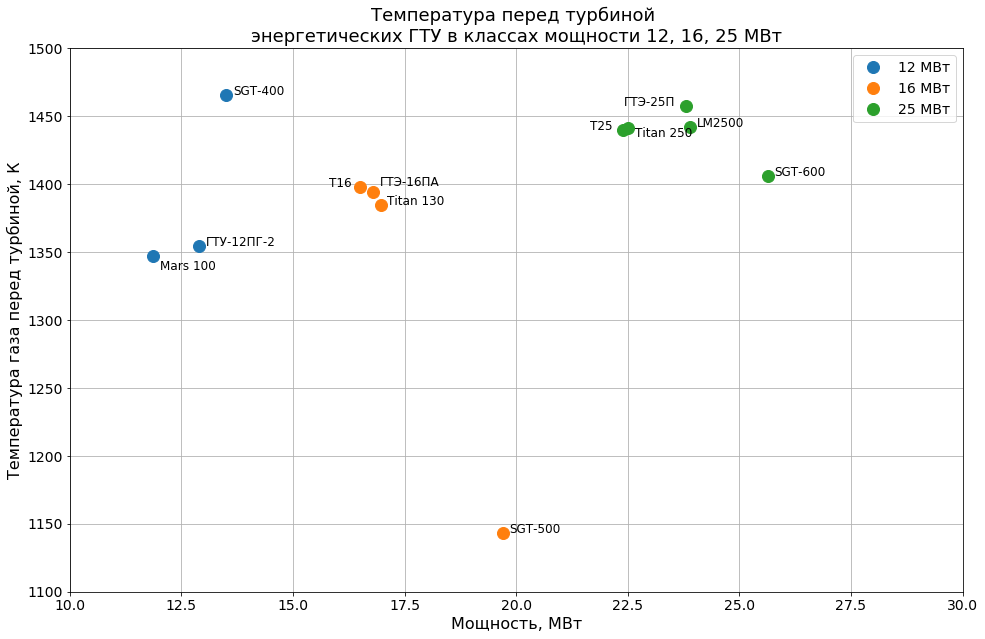

In [54]:
plt.figure(figsize=(16, 10))

plt.plot(class12MW.N, class12MW.T_gas, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.T_gas[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.T_gas[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] + 0.15, class12MW.T_gas[2] - 10, class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.T_gas, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] + 0.15, class16MW.T_gas[0] + 5, class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.T_gas[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.T_gas[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] - 0.7, class16MW.T_gas[3], class16MW.Engine[3], fontsize=12)

plt.plot(class25MW.N, class25MW.T_gas, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.T_gas[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.T_gas[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] + 0.15, class25MW.T_gas[2] - 7, class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.T_gas[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] - 0.75, class25MW.T_gas[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Температура газа перед турбиной, К', fontsize=16)
plt.title('Температура перед турбиной \nэнергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.ylim(1100, 1500)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots\T_gas.png')

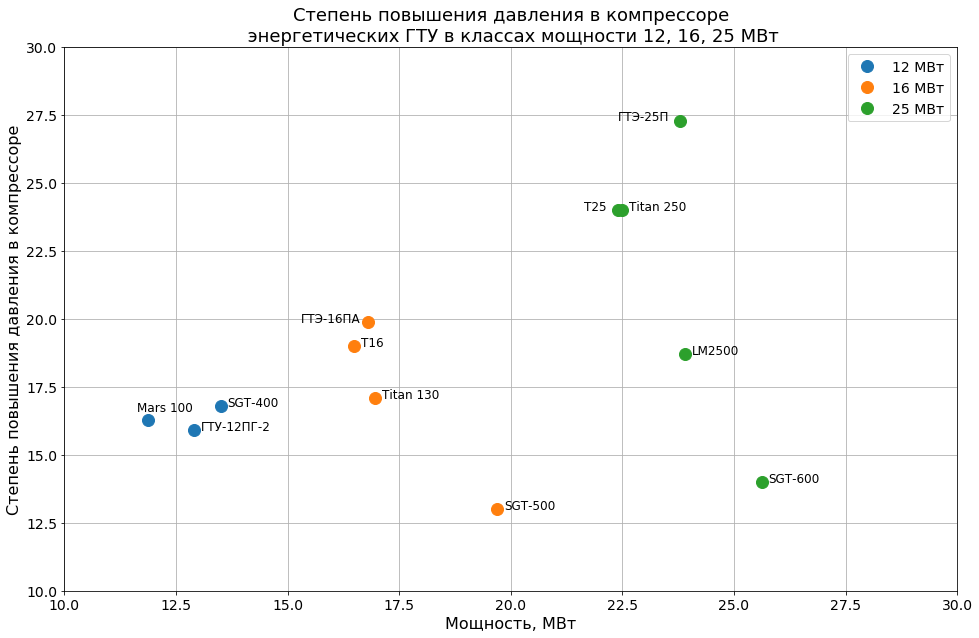

In [55]:
plt.figure(figsize=(16, 10))
plt.plot(class12MW.N, class12MW.pi_c, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.pi_c[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.pi_c[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] - 0.25, class12MW.pi_c[2] + 0.3, class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.pi_c, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 1.5, class16MW.pi_c[0], class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.pi_c[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.pi_c[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] + 0.15, class16MW.pi_c[3], class16MW.Engine[3], fontsize=12)

plt.plot(class25MW.N, class25MW.pi_c, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.pi_c[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.pi_c[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] + 0.15, class25MW.pi_c[2], class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.pi_c[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] - 0.75, class25MW.pi_c[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Степень повышения давления в компрессоре', fontsize=16)
plt.title('Степень повышения давления в компрессоре\n энергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.ylim(10, 30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots\pi_c.png')

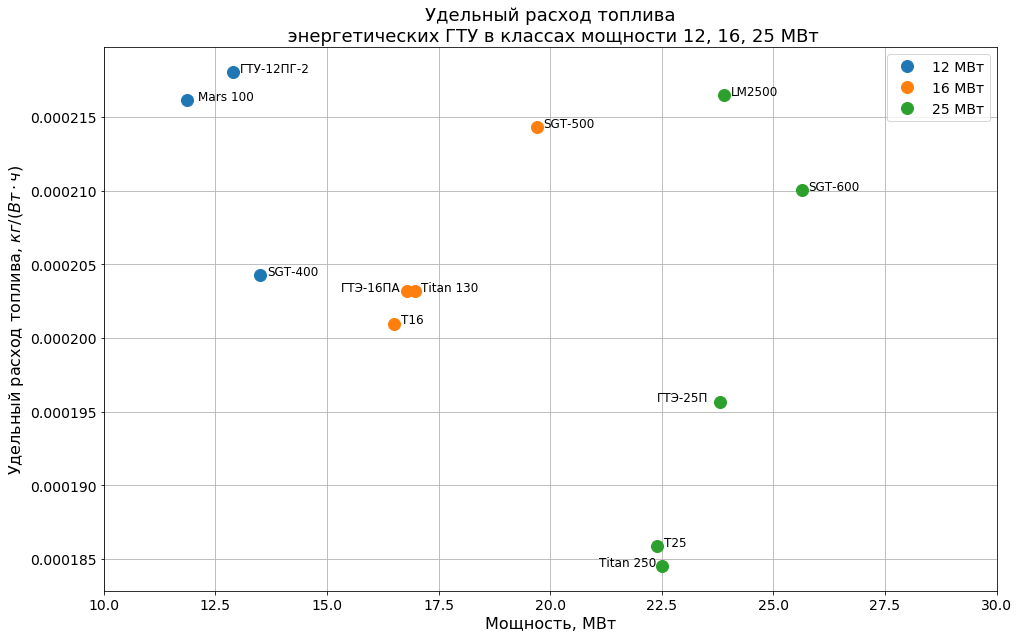

In [56]:
plt.figure(figsize=(16, 10))
plt.plot(class12MW.N, class12MW.C_e, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.C_e[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.C_e[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] + 0.25, class12MW.C_e[2], class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.C_e, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 1.5, class16MW.C_e[0], class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.C_e[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.C_e[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] + 0.15, class16MW.C_e[3], class16MW.Engine[3], fontsize=12)

plt.plot(class25MW.N, class25MW.C_e, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.C_e[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.C_e[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] - 1.4, class25MW.C_e[2], class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.C_e[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] + 0.15, class25MW.C_e[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Удельный расход топлива, $кг / (Вт \cdot ч)$', fontsize=16)
plt.title('Удельный расход топлива\n энергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
# plt.ylim(10, 30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots\c_e.png')